<a href="https://colab.research.google.com/github/Greg8128/4.10-Kaggle-house-prices/blob/main/Kaggle(4_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
331
fold 1, train log rmse 0.079408, valid log rmse 0.129532
fold 2, train log rmse 0.075364, valid log rmse 0.144756
fold 3, train log rmse 0.085714, valid log rmse 0.156413
fold 4, train log rmse 0.099485, valid log rmse 0.146778
fold 5, train log rmse 0.070897, valid log rmse 0.165431
5-fold validation: avg train log rmse: 0.082174, avg valid log rmse: 0.148582, stdev of train log rmse: 0.011107, stdev of train log rmse: 0.013472, 

Done!


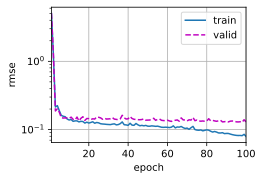

In [ ]:
# Run the following commands: 
'''  
import os
for i in ['d2l', 'torch', 'statistics']:     
    os.system('pip install '+i) 
#'''                                                                            

import hashlib                                                                  
import os
import tarfile
import zipfile
import requests
import statistics
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'                       

# Download a file inserted into DATA_HUB, return the local filename.
def download(name, cache_dir=os.path.join('..', 'data')):  
    
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

# Download and extract an archive file (zip/tar).
def download_extract(name, folder=None): 
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

# Download all files in the DATA_HUB
def download_all(): 
    for name in DATA_HUB:
        download(name)

    
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline



# Set up DATA_HUB for download of test data
DATA_HUB['kaggle_house_train'] = ( 
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

# Get training data and test data
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

# Shape of training and test data
print(train_data.shape)
print(test_data.shape)

# Sample of training data
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])


# Remove ID from training data because it is not useful to the model
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

#td = pd.concat((train_data.iloc[:, 1:-1],))


### Standardize data to have 0 mean and unit variance (equivalent to unit
### standard deviation)

# If test data were inaccessible, mean and standard deviation could be
# calculated from training data 
                                                                                ### FIX: only do standardization using current training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
#tnf = td.dtypes[td.dtypes != 'object'].index

all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)


### Encode discrete values (e.g. zoning types) with one-hot encoding

# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

# 

#print(all_features)

# Convert data to tensor representation
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                            dtype=torch.float32)



loss = nn.MSELoss()
in_features = train_features.shape[1]

# A neural network
print(in_features)
def get_net():
    net = nn.Sequential(nn.Flatten(), nn.Linear(in_features, 256), nn.ReLU(),
                        nn.Linear(256, 128), nn.ReLU(),
                        nn.Linear(128, 64), nn.ReLU(),
                        nn.Linear(64, 10), nn.ReLU(),
                        nn.Linear(10,1))
    return net


# To check the quality of a prediction, take the logarithm
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()


# Training function using the Adam optimization algorithm
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K-fold cross variation
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,        # Should report variance as well as mean
           batch_size):
    train_l_acc, valid_l_acc = [], []
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_acc.append(train_ls[-1])
        valid_l_acc.append(valid_ls[-1])
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return sum(train_l_acc) / k, sum(valid_l_acc) / k, statistics.stdev(train_l_acc), statistics.stdev(valid_l_acc)


# Train the model
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.005, 3, 64                  

train_l, valid_l, train_st, valid_st = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}, '
      f'stdev of train log rmse: {float(train_st):f}, '
      f'stdev of train log rmse: {float(valid_st):f}, ')




# Encode our data as a .csv file to sumbit to Kaggle
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)



print ("\nDone!")